In [1]:
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from time import time

from google.colab import drive
drive.mount('/gdrive')
import glob
drivePath = glob.glob("/gdrive/My Drive/Colab Notebooks/")[0]

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Q1

In [0]:
def readData():
    network = {}
    node2node = {}
    nodes = []
    file = open("petroleum field.txt")
    for line in file.readlines():
        value = line.strip().split()
        nFrom = value[0]
        nTo = value[1]
        network[(nFrom, nTo)] = list(map(lambda x: float(x), value[2:])) + [0]
        if nFrom not in node2node.keys():
            node2node[nFrom] = [nTo]
        else:
            node2node[nFrom] = node2node[nFrom] + [nTo]
        if nFrom not in nodes:
            nodes.append(nFrom)
        if nTo not in nodes:
            nodes.append(nTo)
    file.close()
    return nodes, node2node, network

In [0]:
def BFS(node2node, network):
    '''
    Find augmented path in BFS
    '''
    queue = ["s"]
    father = {}
    while(len(queue)):
        nFrom = queue[0]
        queue = queue[1:]
        for nTo in node2node[nFrom]:
            _, capacity, flow = network[(nFrom, nTo)]
            if capacity > flow and nTo not in queue:
                queue.append(nTo)
                father[nTo] = nFrom
                if nTo == "t":
                    augmentedPath = []
                    curNode = "t"
                    deltaFlow = np.inf
                    while(curNode != "s"):
                        augmentedPath.insert(0, curNode)
                        _, capacity, flow = network[(father[curNode], curNode)]
                        augmentedFlow = capacity - flow
                        if deltaFlow > augmentedFlow:
                            deltaFlow = augmentedFlow
                        curNode = father[curNode]
                    augmentedPath.insert(0, "s")
                    return augmentedPath, deltaFlow
    return [], -1

def updateNetwork(augmentedPath, deltaFlow, network):
    for nFrom, nTo in zip(augmentedPath[:-1], augmentedPath[1:]):
        network[(nFrom, nTo)][-1] = network[(nFrom, nTo)][-1] + deltaFlow

def EK():
    '''
    EK algorithm for max flow
    '''
    nodes, node2node, network = readData()
    maxFlow = 0
    while(True):
        augmentedPath, deltaFlow = BFS(node2node, network)
        if augmentedPath == []:
            break
        updateNetwork(augmentedPath, deltaFlow, network)
        maxFlow += deltaFlow

    cost = np.array(list(network.values()))
    minCost = cost[cost[:, -1] > 0].sum(axis=0)[0]
    return network, minCost, maxFlow

In [0]:
EK()

({('s', 'P1'): [0.0, 205.0, 205.0],
  ('s', 'P2'): [0.0, 75.0, 75.0],
  ('s', 'P3'): [0.0, 95.0, 95.0],
  ('s', 'P4'): [0.0, 195.0, 195.0],
  ('P1', 'B'): [14.0, 200.0, 5.0],
  ('P1', 'C'): [19.0, 200.0, 200.0],
  ('P2', 'A'): [9.0, 200.0, 75.0],
  ('P2', 'B'): [10.0, 200.0, 0],
  ('P3', 'A'): [12.0, 200.0, 95.0],
  ('P3', 'E'): [18.0, 200.0, 0],
  ('P4', 'E'): [26.0, 200.0, 0],
  ('P4', 'F'): [10.0, 200.0, 195.0],
  ('A', 'D'): [25.0, 200.0, 170.0],
  ('B', 'D'): [11.0, 200.0, 5.0],
  ('C', 'D'): [8.0, 200.0, 0],
  ('C', 't'): [14.0, 200.0, 200.0],
  ('D', 't'): [15.0, 200.0, 175.0],
  ('E', 'D'): [4.0, 200.0, 0],
  ('E', 'F'): [7.0, 200.0, 0],
  ('F', 't'): [20.0, 200.0, 195.0]},
 149.0,
 570.0)

In [0]:
def Dijkstra(nodes, node2node, network):
    father = {}
    visitedNodes = ["s"]
    nonVisitedNodes = nodes.copy()
    nonVisitedNodes.remove("s")
    dist = {}
    for node in nonVisitedNodes:
        dist[("s", node)] = np.inf
    dist[("s", "s")] = 0
    while(True):
        curNode = visitedNodes[-1]
        if curNode == "t":
            break
        for nextNode in node2node[curNode]:
            if dist[("s", nextNode)] > dist[("s", curNode)] + network[(curNode, nextNode)][0]:
                dist[("s", nextNode)] = dist[("s", curNode)] + network[(curNode, nextNode)][0]
                father[nextNode] = curNode
        minDist = np.inf
        minDistNode = nonVisitedNodes[0]
        for node in nonVisitedNodes:
            if minDist > dist[("s", node)]:
                minDist = dist[("s", node)]
                minDistNode = node
        visitedNodes.append(minDistNode)
        nonVisitedNodes.remove(minDistNode)
    shortestPath = []
    curNode = "t"
    if len(father):
        while(curNode != "s"):
            shortestPath.insert(0, curNode)
            curNode = father[curNode]
        shortestPath.insert(0, "s")
    return shortestPath, dist[("s", "t")]

def minCostMaxFlow():
    nodes, node2node, network = readData()
    newNetWork = network.copy()
    maxFlow = 0
    while(True):
        shortestPath, _ = Dijkstra(nodes, node2node, network)
        if len(shortestPath) == 0:
            break
        deltaFlow = []
        for nFrom, nTo in zip(shortestPath[:-1], shortestPath[1:]):
            _, capacity, flow = network[(nFrom, nTo)]
            deltaFlow.append(capacity-flow)
        minDeltaFlow = min(deltaFlow)
        maxFlow += minDeltaFlow
        for nFrom, nTo in zip(shortestPath[:-1], shortestPath[1:]):
            network[(nFrom, nTo)][-1] = network[(nFrom, nTo)][-1] + minDeltaFlow
            if network[(nFrom, nTo)][-1] == network[(nFrom, nTo)][1]:
                del network[(nFrom, nTo)]
                node2node[nFrom].remove(nTo)
    cost = np.array(list(newNetWork.values()))
    minCost = cost[cost[:, -1] > 0].sum(axis=0)[0]
    return newNetWork, minCost, maxFlow

In [0]:
minCostMaxFlow()

({('s', 'P1'): [0.0, 205.0, 205.0],
  ('s', 'P2'): [0.0, 75.0, 75.0],
  ('s', 'P3'): [0.0, 95.0, 95.0],
  ('s', 'P4'): [0.0, 195.0, 195.0],
  ('P1', 'B'): [14.0, 200.0, 5.0],
  ('P1', 'C'): [19.0, 200.0, 200.0],
  ('P2', 'A'): [9.0, 200.0, 0],
  ('P2', 'B'): [10.0, 200.0, 75.0],
  ('P3', 'A'): [12.0, 200.0, 0],
  ('P3', 'E'): [18.0, 200.0, 95.0],
  ('P4', 'E'): [26.0, 200.0, 0],
  ('P4', 'F'): [10.0, 200.0, 195.0],
  ('A', 'D'): [25.0, 200.0, 0],
  ('B', 'D'): [11.0, 200.0, 80.0],
  ('C', 'D'): [8.0, 200.0, 0],
  ('C', 't'): [14.0, 200.0, 200.0],
  ('D', 't'): [15.0, 200.0, 175.0],
  ('E', 'D'): [4.0, 200.0, 95.0],
  ('E', 'F'): [7.0, 200.0, 0],
  ('F', 't'): [20.0, 200.0, 195.0]},
 135.0,
 570.0)

In [0]:
def adjacentNodes(node, node2node, network):
    '''
    Get adjacent nodes in one network
    '''
    fathers = []
    if node != "t":
        sons = node2node[node]
    else:
        sons = []
    for nFrom, nTo in network.keys():
        if nTo == node:
            fathers.append(nFrom)
    return fathers, sons

def digitizeEdges():
    '''
    Give each edge a number
    '''
    nodes, node2node, network = readData()
    numNodes = len(nodes)
    numEdges = len(network)
    A = np.zeros((numNodes, numEdges))
    edges = {}
    num = 0
    for pair in network.keys():
        edges[pair] = num
        num += 1
    for n in nodes:
        fathers, sons = adjacentNodes(n, node2node, network)
        for father in fathers:
            A[nodes.index(n), edges[(father, n)]] = 1
        for son in sons:
            A[nodes.index(n), edges[(n, son)]] = -1
    A = A.astype(int)
    print(nodes)
    print(edges)

    # Save A into txt
    f= open("A.txt","w+")
    f.write("param A :\n\t")
    for j in range(numEdges-1):
        f.write("{}\t".format(j+1))
    f.write("{}:=\n".format(j+1+1))
    for i in range(numNodes):
        f.write("{}\t".format(i+1))
        for j in range(numEdges-1):
            f.write("{}\t".format(A[i, j]))
        f.write("{}".format(A[i, j+1]))
        f.write('\n')
    f.write(";")
    f.close()
    
    # Write capacity and cost of each edge into seperate txt
    num = 1
    fCapacity = open("Capacity.txt", "w+")
    fCost = open("Cost.txt", "w+")
    fCapacity.write("param : C : =\n")
    fCost.write("param : cost :=\n")
    for pair in edges.keys():
        fCapacity.write("{}\t{}\n".format(num, int(network[pair][1])))
        fCost.write("{}\t{}\n".format(num, network[pair][0]))
        num += 1
    fCapacity.write(";")
    fCost.write(";")
    fCapacity.close()
    fCost.close()

In [0]:
digitizeEdges()

['s', 'P1', 'P2', 'P3', 'P4', 'B', 'C', 'A', 'E', 'F', 'D', 't']
{('s', 'P1'): 0, ('s', 'P2'): 1, ('s', 'P3'): 2, ('s', 'P4'): 3, ('P1', 'B'): 4, ('P1', 'C'): 5, ('P2', 'A'): 6, ('P2', 'B'): 7, ('P3', 'A'): 8, ('P3', 'E'): 9, ('P4', 'E'): 10, ('P4', 'F'): 11, ('A', 'D'): 12, ('B', 'D'): 13, ('C', 'D'): 14, ('C', 't'): 15, ('D', 't'): 16, ('E', 'D'): 17, ('E', 'F'): 18, ('F', 't'): 19}


In [0]:
def hierarchy(node2node):
    queue = ['s']
    level = {'s': 1}
    node2node['t'] = None
    while(len(queue)):
        nFrom = queue[0]
        queue = queue[1:]
        if nFrom == 't':
            continue
        for nTo in node2node[nFrom]:
            if nTo not in level.keys():
                level[nTo] = level[nFrom] + 1
                queue.append(nTo)
    level['t'] = level['t'] + 1
    return np.array(sorted(level.items(), key=itemgetter(1), reverse=False))

def plot():
    nodes, node2node, _ = readData()
    network, minCost, maxFlow = minCostMaxFlow()
    pos = {}
    hie = hierarchy(node2node)

    scaling = 1.1
    levelNumber = hie[:, 1].astype(int).max()
    #ax = plt.axes()
    stepY = scaling/(levelNumber+1)
    for i in range(levelNumber):
        y = scaling - (i+1)*stepY
        levelNodes = hie[hie[:, 1].astype(float) == i+1][:, 0]
        stepX = scaling / (len(levelNodes)+1)
        for j in range(len(levelNodes)):
            x = (j+1)*stepX
            pos[levelNodes[j]] = (x, y)

    for nFrom, nTo in network.keys():
        xFrom, yFrom = pos[nFrom]
        xTo, yTo = pos[nTo]
        plt.annotate('',xy=(xTo, yTo),xytext=(xFrom, yFrom),arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
        
        _, capacity, flow = network[(nFrom, nTo)]
        plt.text((xFrom+xTo)/2, (yFrom+yTo)/2, "{}/{}".format(int(flow), int(capacity)), horizontalalignment='center',
                verticalalignment='center', fontdict={'size':10, 'color':'green'})
        
    for n in nodes:
        x, y = pos[n]
        plt.text(x, y, n, horizontalalignment='center', verticalalignment='center', fontdict={'size':20, 'color':'red'})
    #plt.show()

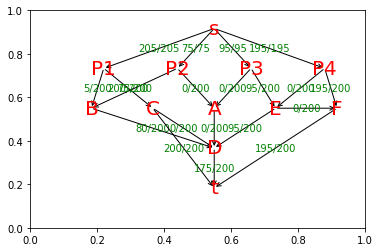

In [0]:
plot()

# Q2

In [0]:
def readDataKiro(fileName):
    file = open(fileName)
    data = [line.strip() for line in file.readlines()]
    file.close()
    Q, nbF, H = np.array(data[0].split()[1::2]).astype(int)
    # Index for deposit
    idxD = int(data[1].split()[1])
    # Index for factory
    idxU = int(data[2].split()[1])
    subcontractCost = []
    stock = []
    costNetwork = np.zeros((nbF+2, nbF+2))
    # Suppose all data is int
    for f in range(nbF):
        line = data[3+f].split()
        subcontractCost.append(int(line[3]))
        stock.append(list(np.array(line[5: 5+H]).astype(int)))
    for line in data[3+nbF:]:
        values = line.split()
        i, j = np.array(values[1:3]).astype(int)
        c = int(values[-1])
        costNetwork[i, j] = c
    return Q, nbF, H, idxD, idxU, subcontractCost, np.array(stock), costNetwork

def getFeasiblePaths(idxD, idxU, costNetwork, group):
    '''
    For each group of providers, we find all feasible
    transport paths
    '''
    paths = []
    num = len(group)
    for i in range(num):
        # Pass only 1 provider
        paths.append([group[i]])
        for j in range(i+1, num):
            # Pass only 2 providers
            paths.append(resortIndex(idxD, idxU, costNetwork, [group[i], group[j]]))
            for m in range(j+1, num):
                # Pass only 3 providers
                paths.append(resortIndex(idxD, idxU, costNetwork, [group[i], group[j], group[m]]))
                for n in range(m+1, num):
                    # Pass only 4 providers
                    paths.append(resortIndex(idxD, idxU, costNetwork, [group[i], group[j], group[m], group[n]]))
    return paths

def resortIndex(idxD, idxU, costNetwork, providers):
    '''
    Resort all providers in one transport with a min cost
    '''
    DfU = []
    for p in providers:
        DfU.append([costNetwork[idxD, p], costNetwork[p, idxU]])
    DfU = np.array(DfU)
    minCostIndex = DfU.argmin(axis=0)
    if minCostIndex[0] != minCostIndex[1]:
        firstProvider = minCostIndex[0]
        lastProvider = minCostIndex[1]
    else:
        minCostIndex = minCostIndex[0]
        DfU[minCostIndex, :] = np.array([np.inf, np.inf])
        scdMinIdx = DfU.argmin(axis=0)
        if DfU[scdMinIdx[0], 0] < DfU[scdMinIdx[1], 1]:
            firstProvider = scdMinIdx[0]
            lastProvider = minCostIndex
        else:
            firstProvider = minCostIndex
            lastProvider = scdMinIdx[1]
    sortedProviders = providers.copy()
    sortedProviders.remove(providers[firstProvider])
    sortedProviders.remove(providers[lastProvider])
    sortedProviders.insert(0, providers[firstProvider])
    sortedProviders.append(providers[lastProvider])
    return sortedProviders

def transportAlongOnePath(Q, idxD, idxU, stock, costNetwork, path, s):
    q = 0
    cost = costNetwork[idxD, path[0]] + costNetwork[path[-1], idxU]
    for i, j in zip(path[:-1], path[1:]):
        cost += costNetwork[i, j]
        q += stock[i, s]
    q += stock[path[-1], s]
    q = min(q, Q)
    return cost, q

def getBestPath(Q, idxD, idxU, stock, costNetwork, group, s):
    paths = getFeasiblePaths(idxD, idxU, costNetwork, group)
    tours = []
    for path in paths:
        tours.append(transportAlongOnePath(Q, idxD, idxU, stock, costNetwork, path, s))
    tours = np.array(tours)
    maxLoadIdx = tours.argmax(axis=0)[1]
    minCostIdx = tours.argmin(axis=0)[0]
    if maxLoadIdx == minCostIdx:
        return paths[maxLoadIdx], tours[maxLoadIdx]
    else:
        return paths[maxLoadIdx], tours[maxLoadIdx]

def updateStock(bestPath, stock, s):
    path = bestPath[0]
    cost, load = bestPath[1]
    loadForEachProvider = []
    for p in path:
        delta = min(stock[p, s], load)
        stock[p, s] = stock[p, s] - delta
        load -= delta
        loadForEachProvider.append(delta)
    return loadForEachProvider

def isStockNull(group, stock, s):
    return stock[group, s].sum() == 0

def getP(Q, idxD, idxU, stock, costNetwork, group, s):
    P = []
    totalCost = 0
    while(not isStockNull(group, stock, s)):
        bestPath = getBestPath(Q, idxD, idxU, stock, costNetwork, group, s)
        path = bestPath[0]
        cost, load = bestPath[1]
        totalCost += cost
        loadForEachProvider = updateStock(bestPath, stock, s)
        P.append([s, path, loadForEachProvider, cost, load])
    return P, totalCost



def isLegalGroup(G):
    '''
    >>> a = np.array([[0, 1, 0], [1, 0, 1], [0, 0, 0]])
    >>> isLegalGroup(a)
    True
    '''
    rows = G.sum(axis=1)
    cols = G.sum(axis=0)
    return np.alltrue(rows<=4) and np.alltrue(cols==1)

def getRandomGroup(notSubcontract):
    nbNotSubcontract = len(notSubcontract)
    G = np.zeros((nbNotSubcontract, nbNotSubcontract))
    for i in range(nbNotSubcontract):
        rand = np.random.randint(0, nbNotSubcontract)
        G[rand, i] = 1
        while not np.alltrue(G.sum(axis=1)<=4):
            G[rand, i] = 0
            rand = np.random.randint(0, nbNotSubcontract)
            G[rand, i] = 1
    return G

def reduceNbGrp(G):
    gCopy = np.array(G).copy()
    return np.delete(gCopy, np.nonzero(gCopy.sum(axis=1) == 0)[0], 0)

def crossoverEA1(G):
    gCopy = G.copy()
    numGrp, numF = gCopy.shape
    i, j = 0, 0
    while i==j and numGrp!=1:
        i = np.random.randint(0, numGrp)
        j = np.random.randint(0, numGrp)
    pi = gCopy[i, :]
    pj = gCopy[j, :]
    si, sj = np.zeros(numF), np.zeros(numF)
    si[0::2] = pi[0::2]
    si[1::2] = pj[1::2]
    sj[0::2] = pj[0::2]
    sj[1::2] = pi[1::2]
    gCopy[i, :] = si
    gCopy[j, :] = sj
    return gCopy

def mutate(G):
    gCopy = G.copy()
    numGrp, numF = gCopy.shape
    fi = np.random.randint(0, numF)
    pos = np.nonzero(gCopy[:, fi] == 1)[0][0]
    gi = np.random.randint(0, numGrp)
    gCopy[pos, fi] = 0
    gCopy[gi, fi] = 1
    return gCopy

def getFitness(notSubcontract, G, Q, nbF, idxD, idxU, stock, costNetwork, H):
    stockCopy = stock.copy()
    cost = 0
    reducedG = reduceNbGrp(G)
    P = []
    numP = 0
    for nbG in range(reducedG.shape[0]):
        group = notSubcontract[np.nonzero(reducedG[nbG, :]==1)[0]]
        for s in range(H):
            p, eachCost = getP(Q, idxD, idxU, stockCopy, costNetwork, group, s)
            numP += len(p)
            cost += eachCost
            P.append(p)
    return cost, P, numP

def EA1(notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H):
    nbNotSubcontract = len(notSubcontract)
    # Initial solution
    G = getRandomGroup(notSubcontract)
    fitness, P, numP = getFitness(notSubcontract, G, Q, nbF, idxD, idxU, stock, costNetwork, H)
    for i in range(1):
        newG = mutate(crossoverEA1(G))
        while not isLegalGroup(newG):
            newG = mutate(crossoverEA1(G))
        newFitness, newP, newNumP = getFitness(notSubcontract, newG, Q, nbF, idxD, idxU, stock, costNetwork, H)
        if newFitness < fitness:
            G = newG.copy()
            fitness = newFitness
            P = newP
            numP = newNumP
    return G, fitness, P, numP


def crossoverEA2(sols):
    numGrp, numF = np.array(sols[0]).shape
    numSols = len(sols)
    newSols = []
    for i in range(numSols):
        for j in range(i+1, numSols):
            soli = np.array(sols[i])
            solj = np.array(sols[j])
            newSoli, newSolj = np.zeros((numGrp, numF)), np.zeros((numGrp, numF))
            newSoli[:, 0::2] = soli[:, 0::2]
            newSoli[:, 1::2] = solj[:, 1::2]
            newSolj[:, 0::2] = solj[:, 0::2]
            newSolj[:, 1::2] = soli[:, 1::2]
            newSoli = mutate(newSoli)
            newSolj = mutate(newSolj)
            if isLegalGroup(newSoli):
                newSols.append(newSoli)
            if isLegalGroup(newSolj):
                newSols.append(newSolj)
    return newSols

def getRandGrps(notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H, num=5):
    nbNotSubcontract = len(notSubcontract)
    grps = []
    fits = []
    Ps = []
    numPs = []
    for i in range(num):
        G = getRandomGroup(notSubcontract)
        grps.append(G)
        fitness, P, numP = getFitness(notSubcontract, G, Q, nbF, idxD, idxU, stock, costNetwork, H)
        fits.append(fitness)
        Ps.append(P)
        numPs.append(numP)
    return grps, fits, Ps, numPs


def EA2(notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H):
    generation = 1
    grps, fits, Ps, numPs = getRandGrps(notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H)
    for g in range(generation):
        _, fits, grps, Ps, numPs = select(grps, fits, grps, Ps, numPs)
        for grp in crossoverEA2(grps):
            grps.append(grps)
            fitness, P, numP = getFitness(notSubcontract, grp, Q, nbF, idxD, idxU, stock, costNetwork, H)
            fits.append(fitness)
            Ps.append(P)
            numPs.append(numP)
        newGrps, newFits, newPs, newNumPs = getRandGrps(notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H)
        grps= grps + newGrps
        fits = fits + newFits
        Ps = Ps + newPs
        numPs = numPs + newNumPs
    _, fits, grps, Ps, numPs = select(grps, fits, grps, Ps, numPs)
    return reduceNbGrp(grps[0]), fits[0], Ps[0], numPs[0]


def subcontract(nbF):
    f = np.random.randint(2, size=nbF)
    f= np.zeros(nbF)
    notSubcontract = np.nonzero(f==0)[0]
    isSubcontract = np.nonzero(f==1)[0]
    return isSubcontract, notSubcontract

def calculateFitness(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, sol, threshold):
    if threshold == None:
      threshold = np.inf
    costSubcontract = np.matmul(sol, subcontractCost)

    notSubcontract = np.nonzero(sol==0)[0]
    if  costSubcontract < threshold and len(notSubcontract):
        grp, costNotSubcontract, P, numP = EA1(notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H)
    else:
        grp = []
        costNotSubcontract = 0
        P = []
        numP = 0
    return costSubcontract+costNotSubcontract, grp, P, numP

def getOffsprings(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, sols, threshold):
    numSols = len(sols)
    newSols = []
    newFits = []
    newGrps = []
    newP = []
    newN = []
    for i in range(numSols):
        for j in range(i+1, numSols):
            soli = sols[i]
            solj = sols[j]
            newSoli, newSolj = np.zeros(nbF), np.zeros(nbF)
            newSoli[0::2] = soli[0::2]
            newSoli[1::2] = solj[1::2]
            newSolj[0::2] = solj[0::2]
            newSolj[1::2] = soli[1::2]
            randi = np.random.randint(0, nbF)
            randj = np.random.randint(0, nbF)
            newSoli[randi] = 1-newSoli[randi]
            newSolj[randj] = 1-newSolj[randj]
            newSols.append(newSoli)
            newSols.append(newSolj)
            fiti, grpi, pi, ni = calculateFitness(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, newSoli, threshold)
            fitj, grpj, pj, nj = calculateFitness(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, newSolj, threshold)
            newFits.append(fiti)
            newFits.append(fitj)
            newGrps.append(grpi)
            newGrps.append(grpj)
            newP.append(pi)
            newP.append(pj)
            newN.append(ni)
            newN.append(nj)
    return newSols, newFits, newGrps, newP, newN

def select(sols, fits, grps, P, N, nbWinners=3):
    solsCopy = np.array(sols.copy())
    fitsCopy = np.array(fits.copy())
    grpsCopy = np.array(grps.copy())
    pCopy = np.array(P.copy())
    nCopy = np.array(N.copy())
    w = np.argsort(fitsCopy)[:nbWinners]
    return solsCopy[w], fitsCopy[w].tolist(), grpsCopy[w].tolist(), pCopy[w].tolist(), nCopy[w].tolist()

def EA(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, numSols=5):
    sols = []
    fits = []
    grps = []
    P = []
    N = []
    for sol in [np.zeros(nbF), np.ones(nbF)]:
        sols.append(sol)
        fit, grp, p, num = calculateFitness(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, sol, None)
        fits.append(fit)
        grps.append(grp)
        P.append(p)
        N.append(num)
    threshold = fits[0]
    for num in range(numSols):
        sol = np.random.randint(2, size=nbF)
        sols.append(sol)
        fit, grp, p, num = calculateFitness(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, sol, threshold)
        fits.append(fit)
        grps.append(grp)
        P.append(p)
        N.append(num)
    generations = 10
    for g in range(generations):
        sols, fits, grps, P, N = select(sols, fits, grps, P, N)
        newSols, newFits, newGrps, newP, newN = getOffsprings(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, sols, threshold)
        sols = sols.tolist() + newSols
        fits = fits + newFits
        grps = grps + newGrps
        P = P + newP
        N = N + newN
        threshold = fits[0]

        print("Generation: ", g, fits[0])
        output(nbF, sol[0], fits[0], reduceNbGrp(grps[0]), P[0], N[0])

    sols, fits, grps, P, N = select(sols, fits, grps, P, N)
    return sols[0], fits[0], reduceNbGrp(grps[0]), P[0], N[0]


def SA(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H):
    T = 1000
    TLimit = 1
    sol = np.random.randint(2, size=nbF)
    fit, grp, p = calculateFitness(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, sol)
    TDecayRate = 0.9
    while T>=TLimit:
        nSol = sol.copy()
        rand = np.random.randint(0, nbF)
        nSol[rand] = 1-nSol[rand]
        nFit, nGrp, nP = calculateFitness(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, nSol)
        dff = nFit-fit
        if dff < 0:
            sol = nSol
        else:
            if np.exp(-dff/T) > np.random.rand():
                sol = nSol
        T = T*TDecayRate
    fit, grp, p = calculateFitness(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, sol)
    return sol, fit, reduceNbGrp(grp), p


def output(nbF, sol, fit, grp, P, num):
    notSubcontract = np.nonzero(sol==0)[0].tolist()
    file= open(drivePath+"/usine/{}.txt".format(fit), "w+")
    file.write("x {} f {}\n".format(int(sol.sum()), " ".join(np.nonzero(sol==1)[0].astype(str))))
    file.write("y {}\n".format(num))
    file.write("z {}\n".format(grp.shape[0]))
    for c in range(grp.shape[0]):
        file.write("C {} n {} f {}\n".format(c, int(grp[c, :].sum()), " ".join(np.nonzero(grp[c, :]==1)[0].astype(str))))
    count = 0
    for p in P:
        for ep in p:
            idx = []
            for f in ep[1]:
                idx.append(notSubcontract.index(f))
            g = np.nonzero(grp[:, idx]==1)[0].tolist()
            assert g.count(g[0])==len(g), "check matrix G"
            s = ep[0]
            n = len(ep[1])
            line = "P {} g {} s {} n {}".format(count, g[0], s, n)
            for f, load in zip(ep[1], ep[2]):
                suf = " f {} {}".format(f, int(load))
                line = line + suf
            file.write(line)
            file.write("\n")
            count += 1
    file.close()

In [6]:
def debug():
    fileName = drivePath + "exampleData.csv"
    fileName = drivePath + "usine.csv"
    #fileName = drivePath + "kiro/kiro326.csv"

    t0 = time()
    Q, nbF, H, idxD, idxU, subcontractCost, stock, costNetwork = readDataKiro(fileName)
    
    '''
    sols = np.mat(np.random.randint(2, size=(10000000, nbF)))
    fits = (sols * np.mat(subcontractCost).T)
    print(np.nonzero(fits.A<3915416822))
    '''

    isSubcontract, notSubcontract = subcontract(nbF)
    
    G, fit, P, numP = EA1(notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H)
    #G, fit, P, numP = EA2(notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H)
    sol = np.zeros(nbF)
    grp = reduceNbGrp(G)
    num = numP

    
    #sol, fit, grp, P = SA(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H)

    #sol, fit, grp, P, num = EA(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H)
    output(nbF, sol, fit, grp, P, num)
    
    print("finished with {} minutes".format(round((time()-t0)/60, 2)))
    return P

debug()

finished with 0.03 minutes


[[[0, [201], [370], 541751.0, 370.0]],
 [[1, [201], [510], 541751.0, 510.0]],
 [[2, [201], [390], 541751.0, 390.0]],
 [[3, [201], [530], 541751.0, 530.0]],
 [[4, [201], [700], 541751.0, 700.0]],
 [[5, [201], [640], 541751.0, 640.0]],
 [[6, [201], [570], 541751.0, 570.0]],
 [[7, [201], [660], 541751.0, 660.0]],
 [[0, [82, 130], [0, 4831], 687355.0, 4831.0]],
 [[1, [82, 130], [880, 7830], 687355.0, 8710.0]],
 [[2, [82, 130], [4400, 7996], 687355.0, 12396.0]],
 [[3, [82, 130], [3520, 8330], 687355.0, 11850.0]],
 [[4, [82, 130], [4400, 8600.0], 687355.0, 13000.0],
  [4, [82, 130], [0, 3228], 687355.0, 3228.0]],
 [[5, [82, 130], [6160, 6840.0], 687355.0, 13000.0],
  [5, [82, 130], [0, 5155], 687355.0, 5155.0]],
 [[6, [82, 130], [5280, 7720.0], 687355.0, 13000.0],
  [6, [82, 130], [0, 4108], 687355.0, 4108.0]],
 [[7, [82, 130], [3520, 9480.0], 687355.0, 13000.0],
  [7, [82, 130], [0, 2515], 687355.0, 2515.0]],
 [[0, [233, 288, 316], [840, 0, 12160.0], 2623993.0, 13000.0],
  [0, [233, 288, 31

In [0]:
3915416822.0
finished with 25.58m

In [0]:
38405388515.0/231026319148

0.1662381526773006